In [ ]:
!pip install datasets
!pip install sentence-transformers

In [3]:
# Warning control and basic packages
import scipy
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

# transformer packages
from datasets import load_dataset
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer

warnings.filterwarnings('ignore')

In [ ]:
# setting up the model
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

In [5]:
  # obtain the vocabulary of the model

vocab = tokenizer.get_vocab()
print(len(vocab))

30522


In [6]:
# whats the shape of a vocab vector
model.embeddings.word_embeddings.weight.shape

torch.Size([30522, 768])

In [7]:
# print items from index 101 to 110 in the vocab dictionary

for i, (token, id) in enumerate(vocab.items()):
    if 100 < i < 110:
        print(f'{token}: {id}')

[CLS]: 101
[SEP]: 102
[MASK]: 103
[unused99]: 104
[unused100]: 105
[unused101]: 106
[unused102]: 107
[unused103]: 108
[unused104]: 109


In [8]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

In [9]:
messages[0:3]

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

In [10]:
encoded_tokens = tokenizer(messages[0:3], padding=True, truncation=True, return_tensors='pt')

In [11]:
encoded_tokens.keys()
# attention mask -> what to memorize what to forget
encoded_tokens

{'input_ids': tensor([[ 101, 1045, 2066, 2026, 3042,  102,    0,    0],
        [ 101, 2026, 3042, 2003, 2025, 2204, 1012,  102],
        [ 101, 2115, 3526, 9864, 3504, 2307, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])}

In [12]:
with torch.no_grad():
  output = model(**encoded_tokens)

token_embeddings = output.last_hidden_state
token_embeddings.shape

torch.Size([3, 8, 768])

In [13]:
cls_embedding = output.last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)
cls_embedding.shape

torch.Size([3, 768])

### Now let's make this a function and get sentence embeddings!

In [14]:
def get_sentence_embeddings(sentences, model, tokenizer):
  encoded_tokens = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
  with torch.no_grad():
    # embed the sentence
    output = model(**encoded_tokens)
  # obtain token embeddings - these are at token level
  embeddings = output.last_hidden_state
  # use attention mask to expand
  input_attention_mask = encoded_tokens['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
  #### NOTE: use CLS token, or averaging?
  # We are trying to create a single "sentence embedding" from a list of token embeddings that come from a sentence.!!
  # obtain values for padded and non-padded embeddings, and sum the sentences for a single representation
  mean_pool_sentence_embeddings = torch.sum(embeddings * input_attention_mask, dim=1) / torch.clamp(input_attention_mask.sum(1), min=1e-9)
  return mean_pool_sentence_embeddings.tolist()

In [15]:
embedding_list = get_sentence_embeddings(messages, model, tokenizer)

In [16]:
len(embedding_list[0])

768

### Let's find cosine similarity

In [17]:
def cosine_similarity(embedding_list):
  batch_norm = torch.norm(embedding_list, dim=1, keepdim=True)
  batch_norm_normalized = embedding_list / batch_norm
  cosine_similarity = torch.matmul(batch_norm_normalized, batch_norm_normalized.T)
  return cosine_similarity

In [18]:
cosine_similarity(torch.tensor(embedding_list))

tensor([[1.0000, 0.6706, 0.6223, 0.5097, 0.4791, 0.5275, 0.4663, 0.5967, 0.5226,
         0.5316, 0.5472],
        [0.6706, 1.0000, 0.7386, 0.5452, 0.4824, 0.5225, 0.5102, 0.4963, 0.5406,
         0.5500, 0.5267],
        [0.6223, 0.7386, 1.0000, 0.5704, 0.5194, 0.5708, 0.5080, 0.5507, 0.5675,
         0.6198, 0.6109],
        [0.5097, 0.5452, 0.5704, 1.0000, 0.5663, 0.6145, 0.5932, 0.5241, 0.6226,
         0.6670, 0.6383],
        [0.4791, 0.4824, 0.5194, 0.5663, 1.0000, 0.6443, 0.5459, 0.4814, 0.5371,
         0.4936, 0.4851],
        [0.5275, 0.5225, 0.5708, 0.6145, 0.6443, 1.0000, 0.5591, 0.6349, 0.6521,
         0.5536, 0.5689],
        [0.4663, 0.5102, 0.5080, 0.5932, 0.5459, 0.5591, 1.0000, 0.5903, 0.5745,
         0.4736, 0.5091],
        [0.5967, 0.4963, 0.5507, 0.5241, 0.4814, 0.6349, 0.5903, 1.0000, 0.5715,
         0.5137, 0.5794],
        [0.5226, 0.5406, 0.5675, 0.6226, 0.5371, 0.6521, 0.5745, 0.5715, 1.0000,
         0.6136, 0.6302],
        [0.5316, 0.5500, 0.6198, 0.66

In [19]:
# Helper function to plot similarity matrix
def plot_similarity(labels, features, rotation):
    sim = cosine_similarity(features)
    sns.set_theme(font_scale=0.8)
    g = sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return g

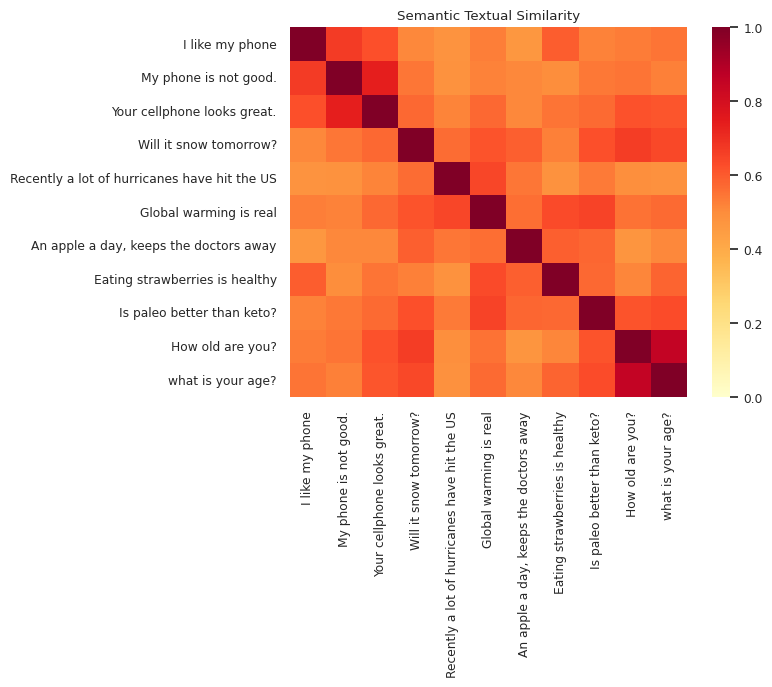

In [20]:
plot_similarity(messages, torch.tensor(embedding_list), 90);

### Load dataset, apply embedding, perform similarity

In [ ]:
hgf_dataset = load_dataset('mteb/stsbenchmark-sts', split='train')

In [22]:
hgf_dataset

Dataset({
    features: ['split', 'genre', 'dataset', 'year', 'sid', 'score', 'sentence1', 'sentence2'],
    num_rows: 5749
})

In [23]:
df = hgf_dataset.to_pandas()
df = df[['sentence1', 'sentence2', 'score']]
df.head(3)

,sentence1,sentence2,score
0,A plane is taking off.,An air plane is taking off.,5.0
1,A man is playing a large flute.,A man is playing a flute.,3.8
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.8


In [24]:
df.shape

(5749, 3)

In [25]:
df = df.iloc[:500]

In [26]:
# normalize the score to be from 0-1
df['score_normalized'] = df['score']/5

In [27]:
df['sent1_embeddings'] = get_sentence_embeddings(df['sentence1'].tolist(), model, tokenizer)
df['sent2_embeddings'] = get_sentence_embeddings(df['sentence2'].tolist(), model, tokenizer)

In [28]:
# Adjusted normalize_embeddings function to handle individual embeddings
def normalize_embedding(embedding):
    embedding_tensor = torch.tensor(embedding)  # Ensure it's a tensor
    norm = torch.norm(embedding_tensor)  # Compute the norm (magnitude)
    return embedding_tensor / norm  # Return the normalized embedding

# Apply the normalization to each embedding in the dataframe
df['sent1_embeddings_normalized'] = df['sent1_embeddings'].apply(normalize_embedding)
df['sent2_embeddings_normalized'] = df['sent2_embeddings'].apply(normalize_embedding)


In [29]:
# Dot product normalized vectors to obtain similarity scores
df['cosine_similarity'] = df.apply(
    lambda row: torch.dot(
        torch.tensor(row['sent1_embeddings_normalized']),
        torch.tensor(row['sent2_embeddings_normalized'])
    ).item(),
    axis=1
)

In [30]:
df.head(3)

,sentence1,sentence2,score,score_normalized,sent1_embeddings,sent2_embeddings,sent1_embeddings_normalized,sent2_embeddings_normalized,cosine_similarity
0,A plane is taking off.,An air plane is taking off.,5.0,1.00,"[0.38721591234207153, -0.28982171416282654, 0....","[0.3878622353076935, -0.15059958398342133, 0.1...","[tensor(0.0345), tensor(-0.0259), tensor(0.011...","[tensor(0.0348), tensor(-0.0135), tensor(0.012...",0.976716
1,A man is playing a large flute.,A man is playing a flute.,3.8,0.76,"[0.2880154252052307, 0.40864768624305725, -0.4...","[0.26557672023773193, 0.23370926082134247, -0....","[tensor(0.0261), tensor(0.0370), tensor(-0.042...","[tensor(0.0250), tensor(0.0220), tensor(-0.042...",0.975055
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.8,0.76,"[0.5903072953224182, 0.093716099858284, -0.112...","[0.5350787043571472, 0.08301504701375961, -0.2...","[tensor(0.0556), tensor(0.0088), tensor(-0.010...","[tensor(0.0501), tensor(0.0078), tensor(-0.021...",0.967443


In [33]:
# check th epearson correlation between the BERT embedding and annotations.
# if these are low, means they are significantly different
pearson_corr = scipy.stats.pearsonr(df['score'], df['cosine_similarity'])
print(f'Pearson correlation coefficient = {pearson_corr[0]}\np-value = {pearson_corr[1]}')

Pearson correlation coefficient = 0.373376749606669
p-value = 5.495491416578967e-18


### Now Let's use sentence transformers, for sentence embeddings

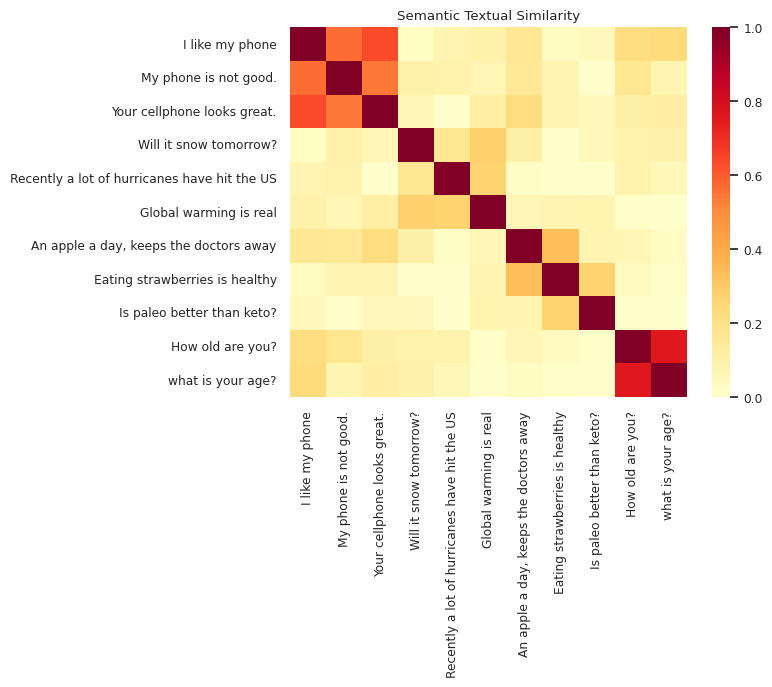

In [46]:

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(messages)  # encode the sentences
embeddings = torch.tensor(embeddings)  # Convert to tensor

# plot_similarity function
plot_similarity(messages, embeddings, 90);

In [53]:
# get sentence embeddings
def sentence_transformer_embeddings(sentences, model):
  embeddings = model.encode(sentences)
  return embeddings

df['sbert_sent1_embeddings'] = df['sentence1'].apply(lambda x: sentence_transformer_embeddings(x, model))
df['sbert_sent2_embeddings'] = df['sentence2'].apply(lambda x: sentence_transformer_embeddings(x, model))

In [54]:
# computing the norm, and normalizing
# Convert embeddings to tensors
sent1_embeddings_tensor = torch.tensor(df['sbert_sent1_embeddings'].tolist())
sent2_embeddings_tensor = torch.tensor(df['sbert_sent2_embeddings'].tolist())

# Compute the norm of each embedding
sent1_norm = torch.norm(sent1_embeddings_tensor, dim=1, keepdim=True)
sent2_norm = torch.norm(sent2_embeddings_tensor, dim=1, keepdim=True)

# Normalize the embeddings by dividing by their norms
df['sbert_sent1_embeddings_normalized'] = (sent1_embeddings_tensor / sent1_norm).tolist()
df['sbert_sent2_embeddings_normalized'] = (sent2_embeddings_tensor / sent2_norm).tolist()


In [57]:
df['sbert_similarity_score'] = df.apply(
    lambda row: torch.dot(
        torch.tensor(row['sbert_sent1_embeddings_normalized']),
        torch.tensor(row['sbert_sent2_embeddings_normalized'])
    ).item(),
    axis=1
)

In [58]:
df.head(3)

,sentence1,sentence2,score,score_normalized,sent1_embeddings,sent2_embeddings,sent1_embeddings_normalized,sent2_embeddings_normalized,cosine_similarity,sbert_sent1_embeddings,sbert_sent2_embeddings,sbert_sent1_embeddings_normalized,sbert_sent2_embeddings_normalized,sbert_similarity_score
0,A plane is taking off.,An air plane is taking off.,5.0,1.00,"[0.38721591234207153, -0.28982171416282654, 0....","[0.3878622353076935, -0.15059958398342133, 0.1...","[tensor(0.0345), tensor(-0.0259), tensor(0.011...","[tensor(0.0348), tensor(-0.0135), tensor(0.012...",0.976716,"[0.06539202, 0.02813002, -0.057565127, 0.06391...","[0.03715866, 0.014116694, -0.058222648, 0.0716...","[0.06539201736450195, 0.028130019083619118, -0...","[0.03715866059064865, 0.01411669421941042, -0....",0.939303
1,A man is playing a large flute.,A man is playing a flute.,3.8,0.76,"[0.2880154252052307, 0.40864768624305725, -0.4...","[0.26557672023773193, 0.23370926082134247, -0....","[tensor(0.0261), tensor(0.0370), tensor(-0.042...","[tensor(0.0250), tensor(0.0220), tensor(-0.042...",0.975055,"[0.08122081, -0.021359593, 0.019954838, -0.087...","[0.043285172, -0.04184168, 0.022553798, -0.057...","[0.08122081309556961, -0.02135959267616272, 0....","[0.043285172432661057, -0.04184167832136154, 0...",0.902032
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.8,0.76,"[0.5903072953224182, 0.093716099858284, -0.112...","[0.5350787043571472, 0.08301504701375961, -0.2...","[tensor(0.0556), tensor(0.0088), tensor(-0.010...","[tensor(0.0501), tensor(0.0078), tensor(-0.021...",0.967443,"[0.01716237, 0.02483488, -0.015900865, 0.00997...","[-0.03815689, -0.033265043, -0.029539527, 0.03...","[0.017162371426820755, 0.024834882467985153, -...","[-0.038156889379024506, -0.033265043050050735,...",0.892001


In [59]:
# check th epearson correlation between the BERT embedding and annotations.
# if these are low, means they are significantly different
pearson_corr = scipy.stats.pearsonr(df['score'], df['sbert_similarity_score'])
print(f'Pearson correlation coefficient = {pearson_corr[0]}\np-value = {pearson_corr[1]}')

Pearson correlation coefficient = 0.9326369248002886
p-value = 1.2934127592790806e-222
